   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

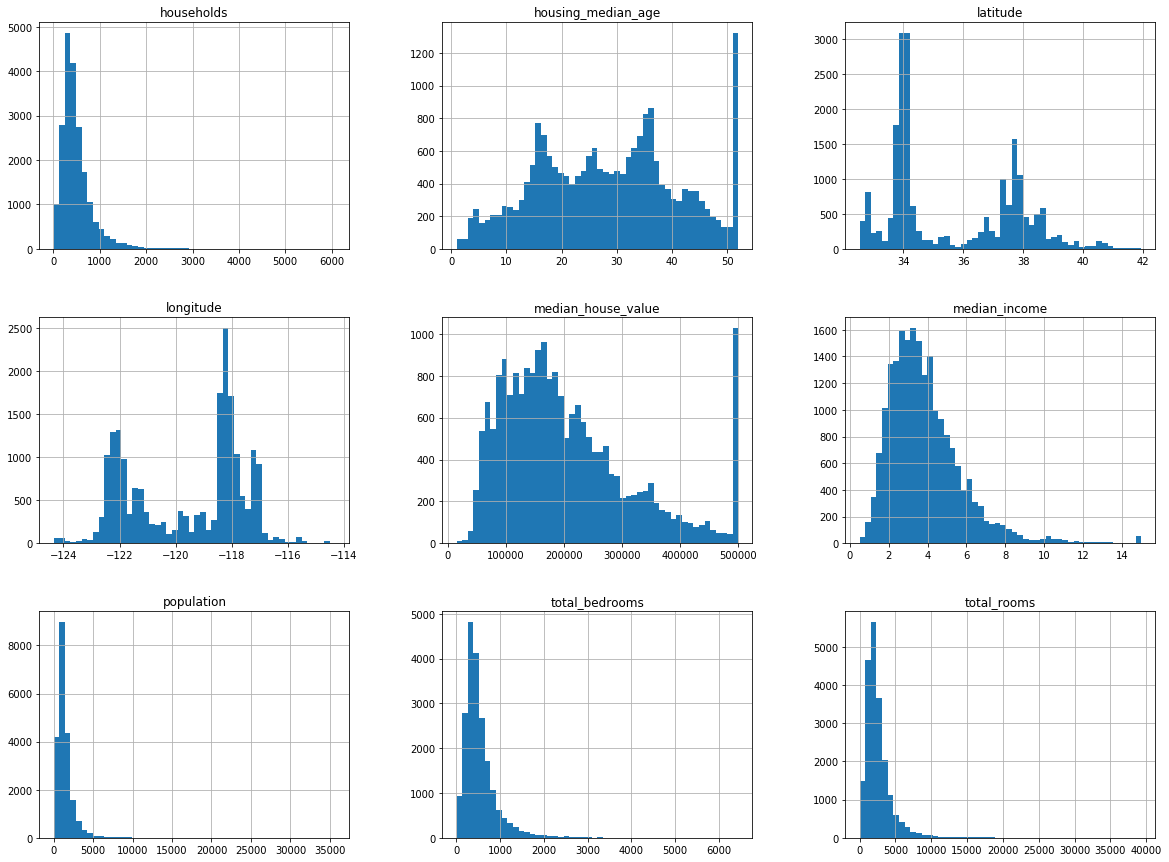

In [1]:
import pandas as pd
housing = pd.read_csv("datasets/housing/housing.csv")
#Looks at districts
print(housing.head())
housing.info()
# Total bedrooms is missing values, we will need to take care of this later
housing.describe()

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
#1. We see median income is not expressed in US dollars, its atually capped at 15 for higher income and 0.5 for lower
# 2.Housing median age and median house value are also capped. Since this is a target value, this is a problemsince you
# can't predict beyond $500k. Either: collect proper labels for districts who are capped, or remove capped districts
# from training set, and also test sets
# 3. Attributes have different scales
# 4. Many historgrams are tail heavy, extend much farther to the right of median. Need to transform to have more
# bell shaped patterns
plt.show()

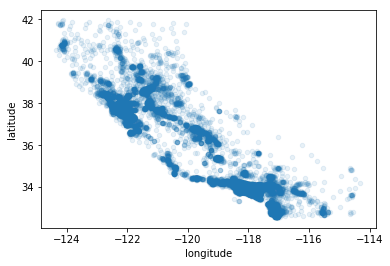

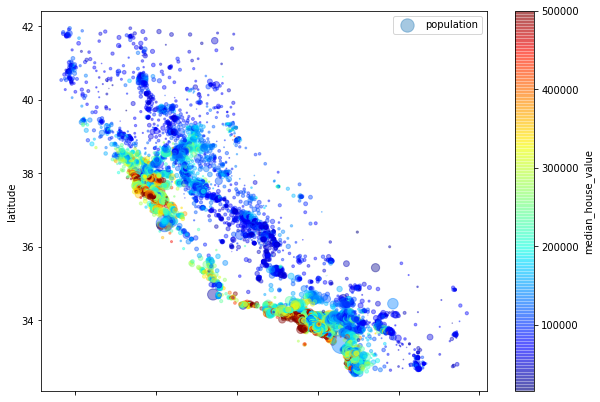

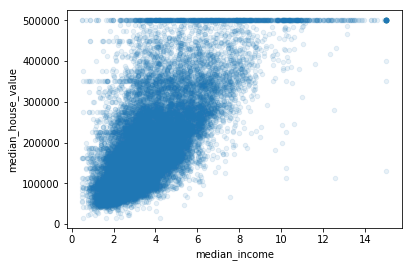

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", 
             figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()


housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [4]:
corr_matrix = housing.corr()
print(corr_matrix['median_house_value'].sort_values(ascending=False))


median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


In [5]:
#Cleaning the data
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split

housing = pd.read_csv("datasets/housing/housing.csv")

#fill in empty bedroom
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

#Filter out scores over 500k
housing = housing[housing['median_house_value'] < 500000]

# One hot encode so we can use this in our ML training
dummies = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = pd.concat([housing, dummies], axis=1)

cols = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households']
scaler = StandardScaler()

housing[cols] = scaler.fit_transform(housing[cols])

labels = housing["median_house_value"].copy()
features = housing.drop("median_house_value", axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std dev:", scores.std())

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

display_scores(lin_rmse_scores)

Scores: [ 62832.71841707  59903.46446636  61503.64469616  60421.3796522
  58943.35392395  56576.38106486  59219.03967215  58396.46848461
  58467.06449257  61118.78436479]
Mean: 59738.2299235
Std dev: 1714.85669419


In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_Rmse_scores = np.sqrt(-scores)

display_scores(tree_Rmse_scores)

Scores: [ 65288.68775424  60998.11895727  62046.30450566  64933.70949439
  62977.82073282  56873.44713802  61407.74565636  63346.34144262
  59939.22535258  58660.6670622 ]
Mean: 61647.2068096
Std dev: 2529.47450389


In [12]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 49320.90047056  46951.31060011  47596.73230588  49167.02795814
  46544.66919662  43485.1822586   45877.07777742  46693.74670519
  45116.50500899  47721.70059184]
Mean: 46847.4852873
Std dev: 1679.07302736


In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [14]:
final_model = grid_search.best_estimator_

print(final_model)

final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
print
final_rmse = np.sqrt(final_mse)
scores = cross_val_score(final_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print(scores)
final_model_scores = np.sqrt(-scores)
display_scores(final_model_scores)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
[ -2.12950293e+09  -2.07627267e+09  -2.11091279e+09  -2.28106993e+09
  -2.04228364e+09  -1.75425655e+09  -1.88843777e+09  -1.93962710e+09
  -1.95612405e+09  -2.06994804e+09]
Scores: [ 46146.53756686  45566.13507519  45944.67093826  47760.54781361
  45191.6324502   41883.84589906  43456.15917088  44041.197794
  44228.0911571   45496.68164365]
Mean: 44971.5499509
Std dev: 1550.23908301
